## Задание

Что в итоге нужно сделать: 

1. сделать сетки (без балансировки и с балансировкой по классам) для разных типов отношений (разные колонки, я чуть позже скину описание колонок). 

2. построить двух готовые - трехголовые сетки для одновременного предсказания нескольких типов отношений

In [1]:
import pandas as pd
import numpy as np

# Посмотрим на данные

texts_and_metadata = pd.read_csv('../data/file1_14998_texts_and_metadata.txt', sep='\t')
texts_and_metadata.head()

,document.id,source,stage,source_text,lemm_text,city,region,date
0,885072939,iqbuzz,2,"[[id178370173|Mia], но у вас же бред написан. ...",mia бред написать какой русский вообще грузин ...,Мурманск,Мурманская область,2015-05-05
1,627169733,iqbuzz,2,Для примера приведу по датам ключевые моменты ...,пример привести дата ключевой момент война хро...,Хабаровск,Хабаровский край,2014-10-13
2,632784345,iqbuzz,2,Фонарь!!!! Сбербанк России надо переименовать ...,фонарь сбербанк россия переименовать сбербанк ...,Сочи,Краснодарский край,2014-10-20
3,632886756,iqbuzz,2,"Олег, дак какая война у нас кроме чеченской бы...",олег дак какой война кроме чеченский про говор...,Москва,Москва,2014-10-20
4,635041456,iqbuzz,2,ДНР. Донецк. Интервью с ополченцем. Позывной \...,донецк интервью ополченец позывной молодая опо...,Москва,Москва,2014-10-23


In [2]:
coding_results = pd.read_csv('../data/file2_14998_coding_results.txt', sep='\t')
coding_results.head()

/tmp/ipykernel_1719947/266747605.py:1: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  coding_results = pd.read_csv('../data/file2_14998_coding_results.txt', sep='\t')


,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
0,883,vk,1,2016-09-25 20:06:34,skuchilina,монгол,1,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,883
1,883,vk,1,2016-09-25 20:06:34,skuchilina,монгол,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,883
2,883,vk,1,2016-09-26 17:08:13,dianasadr,монгол,1,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,883
3,883,vk,1,2016-09-26 17:08:13,dianasadr,монгол,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,883
4,883,vk,1,2016-07-29 15:10:42,Oleg Nagornyy,монгол,1,yes,1,one,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,883


In [6]:
texts_and_metadata[texts_and_metadata['document.id'] == 390022541]

,document.id,source,stage,source_text,lemm_text,city,region,date
5514,390022541,iqbuzz,3,НАРОДНЫЙ СХОД ПРОТИВ МИГРАНТСКОЙ ОККУПАЦИИ НОВ...,народный сход против мигрантский оккупация нов...,Новосибирск,Новосибирская область,2014-03-02


In [6]:
# Выделяю интересующие нас значения

cols = [
    'document.id',
    'stage',
    'assessor',
    'eth_group_to_code',
    'is_ethicity_dangerous_meaning',
    'is_ethicity_superior_meaning',
    'is_ethicity_aggressor_meaning',
    
]
coding_results = coding_results[cols]
coding_results = coding_results.dropna()

**Беру для исследования колонки *is_ethicity_superior_meaning*, *is_ethicity_dangerous_meaning* и *is_ethicity_aggressor_meaning***

Разберёмся с одинаковыми document.id, объединю датафреймы, причём для искомых колонок буду брать наиболее частое значение.

In [7]:
# Способ объединения колонок с одинаковым document.id
# mode=frequent -- устанавливаем наиболее частое значение 
# mode=any -- устанавливаем значение меньшего класса, если оно присутствует в датасете
# mode=unique -- только значения с уникальным document.id

def submit_class(x, mode='frequent', higher_class=None):
    values, counts = np.unique(x.values, return_counts=True)
    indices = x.value_counts().index
 
    if mode == 'any':
        for label in values:
            if label != higher_class:
                return label
    elif mode == 'unique':
        if len(values) != 1:
            return None
        
    
    return values[np.argmax(counts)]

In [12]:
# Выделяем колонки
columns_to_merge = ['is_ethicity_superior_meaning',
                    'is_ethicity_aggressor_meaning',
                    'is_ethicity_dangerous_meaning']

higher_classes = ['irrel', 'irrel', 'no']

def make_data(texts_and_metadata, coding_results, columns_to_merge, text_column, mode=None, higher_classes=None):
    data = pd.DataFrame(texts_and_metadata[['document.id', text_column]])
    
    merge_on = ['document.id', 'eth_group_to_code']
    data = data.merge(coding_results[merge_on], on='document.id')
    
    data[text_column] = data['eth_group_to_code'] + ' ' + data[text_column]
    
    # Если хотим иметь в датасете только уникальные document.id
    if mode != 'eth_group':

        for i, column in enumerate(columns_to_merge):
            data = data.merge(coding_results[['document.id', column, 'eth_group_to_code']],
                              on=['document.id', 'eth_group_to_code'])
            if mode is not None:
                data = data.dropna()
                if higher_classes is not None:
                    data = data.groupby(by='document.id').agg(lambda x: submit_class(x, mode, higher_classes[i]))
                else:
                    data = data.groupby(by=['document.id', 'eth_group_to_code']).agg(lambda x: submit_class(x, mode))
        data = data.dropna()
        data = data.drop_duplicates()

    return data

for text_column in ['lemm_text', 'source_text']:
    # Оставляю различные document id
    mode = 'eth_group'
    data = make_data(texts_and_metadata, coding_results, columns_to_merge, text_column, None, None)
    data.to_csv(f'{mode}_{text_column}.csv')

In [13]:
# Построим графики
data_eth_group = pd.read_csv('eth_group_lemm_text.csv')


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0.5, 0, 'is_ethicity_dangerous_meaning'),
 Text(0, 0.5, ''),
 (0.0, 40000.0)]

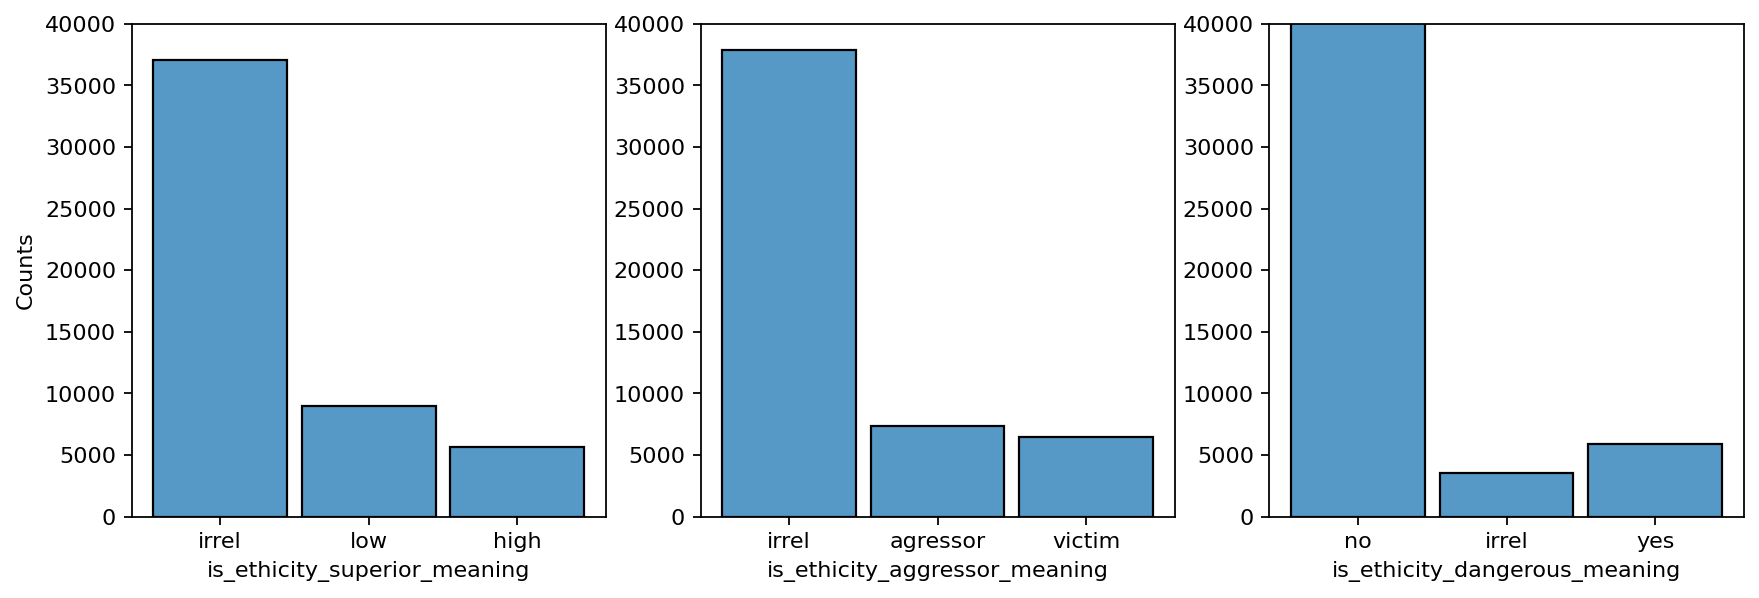

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(13, 4), dpi=160)

sns.histplot(data_eth_group['is_ethicity_superior_meaning'], ax=axs[0], shrink=0.9, )
axs[0].set(xlabel='is_ethicity_superior_meaning', ylabel='Counts', ylim=(0, 40000))

sns.histplot(data_eth_group['is_ethicity_aggressor_meaning'], ax=axs[1], shrink=0.9)
axs[1].set(xlabel='is_ethicity_aggressor_meaning', ylabel='', ylim=(0, 40000))

sns.histplot(data_eth_group['is_ethicity_dangerous_meaning'], ax=axs[2], shrink=0.9)
axs[2].set(xlabel='is_ethicity_dangerous_meaning', ylabel='', ylim=(0, 40000))
